<a href="https://colab.research.google.com/github/gtgindia/-Segmentation-based-industrial-defect-detection/blob/main/2Wobot_Train_defect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [48]:
data_dir1 = "/content/drive/MyDrive/Wobot/WithDef/Class1_def"
data_dir2 = "/content/drive/MyDrive/Wobot/WithDef/Class2_def"
data_dir3 = "/content/drive/MyDrive/Wobot/WithDef/Class3_def"
data_dir4 = "/content/drive/MyDrive/Wobot/WithDef/Class4_def"
data_dir5 = "/content/drive/MyDrive/Wobot/WithDef/Class5_def"
data_dir6 = "/content/drive/MyDrive/Wobot/WithDef/Class6_def"

In [3]:
tdata_dir = "/content/drive/MyDrive/WithDef/test"

In [4]:

def get_mask_seg_ellipse(path_to_img):
    """
    """

    # get the image

    img = mpimg.imread(path_to_img)
    basename = os.path.basename(path_to_img)

    # filename_index, e.g. filename = 1.png
    # filename_index = 1, for extracting coordinates
    filename_index = int(os.path.splitext(basename)[0]) - 1
    # print(filename_index)

    path_to_coordinates = path_to_img.replace(basename, 'labels.txt')
    coordinates = load_coordinates(path_to_coordinates)

    mask = np.zeros_like(img)
    mask = cv2.ellipse(mask, 
                       (int(coordinates[filename_index]['x']), int(coordinates[filename_index]['y'])),
                       (int(coordinates[filename_index]['major_axis']), int(coordinates[filename_index]['minor_axis'])),
                       (coordinates[filename_index]['angle'] / 4.7) * 270,0, 360, (255, 255, 255), -1)

    mask[mask > 0] = 1.

    # print(coordinates[filename_index]['angle'])

    return mask



In [5]:

import cv2
import matplotlib.image as mpimg
import shutil


def get_coordinates(path_to_label, xml):
    """
    """
    with open(path_to_label, encoding='utf-8') as f:
        if xml:
            label_xml = xmltodict.parse(f.read())

            # print(type(label_xml))
            # print(label_xml)

            coordinates_object = label_xml['annotation']['object']
        else:
            label_txt = f.read()
            coordinates_object = label_txt.strip().split('\n')

    return coordinates_object

In [6]:
def load_coordinates(path_to_coor):
    '''
    '''

    coord_dict = {}
    coord_dict_all = {}
    with open(path_to_coor) as f:
        coordinates = f.read().split('\n')
        for coord in coordinates:
            # print(len(coord.split('\t')))
            if len(coord.split('\t')) == 6:
                coord_dict = {}
                coord_split = coord.split('\t')
                # print(coord_split)
                # print('\n')
                coord_dict['major_axis'] = round(float(coord_split[1]))
                coord_dict['minor_axis'] = round(float(coord_split[2]))
                coord_dict['angle'] = float(coord_split[3])
                coord_dict['x'] = round(float(coord_split[4]))
                coord_dict['y'] = round(float(coord_split[5]))
                index = int(coord_split[0]) - 1
                coord_dict_all[index] = coord_dict

    return coord_dict_all


In [7]:

import matplotlib.pyplot as plt
import numpy as np

def plot_ellipse_seg_test(path_to_img):

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)

    plt.imshow(mpimg.imread(path_to_img), cmap='gray')
    plt.subplot(1, 2, 2)
    mask = get_mask_seg_ellipse(path_to_img)
    plt.imshow(mask, cmap='gray')


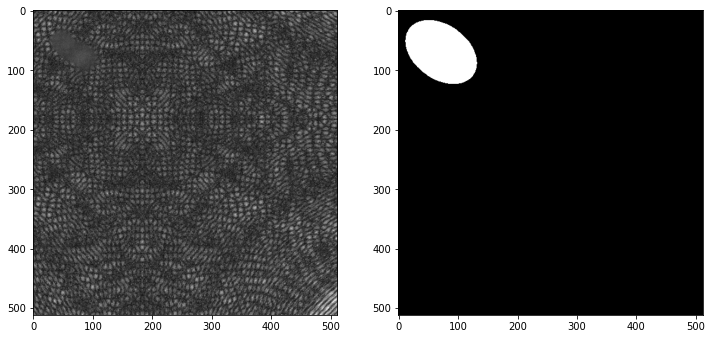

In [8]:
plot_ellipse_seg_test(os.path.join(data_dir1, "11.png"))

In [9]:
IMAGE_CHANNELS = 1

In [10]:
def load_images_masks(path_to_images, img_type, img_format, resize):

    image_names = [x for x in os.listdir(path_to_images) if x.endswith(img_type)]

    image_num = len(image_names)
    images_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])
    labels_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])



    for image_index in range(image_num):
        image_filename = image_names[image_index]
        # print(image_filename)
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)

        mask = get_mask_seg_ellipse(os.path.join(path_to_images, image_filename))


        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))
            mask = cv2.resize(mask, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))
        labels_all[image_index] = np.reshape(mask, (resize[0], resize[1], IMAGE_CHANNELS))

    return images_all, labels_all


In [11]:
X1, y1 = load_images_masks(data_dir1, img_type='png', img_format='gray', resize=(512, 512))

In [12]:
X2, y2 = load_images_masks(data_dir2, img_type='png', img_format='gray', resize=(512, 512))

In [49]:
X3, y3 = load_images_masks(data_dir3, img_type='png', img_format='gray', resize=(512, 512))

In [14]:
X4, y4 = load_images_masks(data_dir4, img_type='png', img_format='gray', resize=(512, 512))

In [15]:
X5, y5 = load_images_masks(data_dir5, img_type='png', img_format='gray', resize=(512, 512))

In [16]:
X6, y6 = load_images_masks(data_dir1, img_type='png', img_format='gray', resize=(512, 512))

In [17]:
X1.shape

(130, 512, 512, 1)

In [18]:
y1.shape

(130, 512, 512, 1)

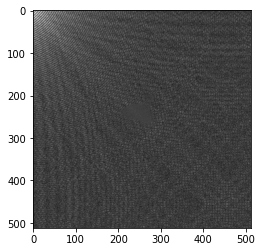

In [19]:
plt.imshow(X1[20,:,:,0], cmap='gray')

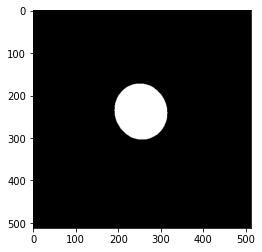

In [20]:
plt.imshow(y1[20,:,:,0], cmap='gray')

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time

In [22]:

def small_unet():
    inputs = Input((512,512, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [23]:
model = small_unet()

In [24]:
model2 = small_unet()
model3 = small_unet()
model4 = small_unet()
model5 = small_unet()
model6 = small_unet()

In [25]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [26]:
model.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
model2.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
model3.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
model4.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
model5.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
model6.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )

In [27]:
import sklearn
from sklearn.model_selection import train_test_split
x_train1, x_valid1, y_train1, y_valid1 = train_test_split(X1, y1, test_size=0.16666,  shuffle= True)
x_train2, x_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size=0.16666,  shuffle= True)
x_train3, x_valid3, y_train3, y_valid3 = train_test_split(X3, y3, test_size=0.16666,  shuffle= True)
x_train4, x_valid4, y_train4, y_valid4 = train_test_split(X4, y4, test_size=0.16666,  shuffle= True)
x_train5, x_valid5, y_train5, y_valid5 = train_test_split(X5, y5, test_size=0.16666,  shuffle= True)
x_train6, x_valid6, y_train6, y_valid6 = train_test_split(X6, y6, test_size=0.16666,  shuffle= True)

In [28]:
import tensorflow as tf

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [30]:
history = model.fit(x_train1, y_train1, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid1,y_valid1), verbose=1)

Epoch 1/25
11/11 [==============================] - 17s 605ms/step - loss: -0.0680 - val_loss: -0.0874
Epoch 2/25
11/11 [==============================] - 3s 289ms/step - loss: -0.0770 - val_loss: -0.1017
Epoch 3/25
11/11 [==============================] - 3s 289ms/step - loss: -0.1003 - val_loss: -0.1406
Epoch 4/25
11/11 [==============================] - 3s 291ms/step - loss: -0.1592 - val_loss: -0.2310
Epoch 5/25
11/11 [==============================] - 3s 292ms/step - loss: -0.2627 - val_loss: -0.3054
Epoch 6/25
11/11 [==============================] - 3s 292ms/step - loss: -0.3491 - val_loss: -0.3234
Epoch 7/25
11/11 [==============================] - 3s 294ms/step - loss: -0.3599 - val_loss: -0.3533
Epoch 8/25
11/11 [==============================] - 3s 296ms/step - loss: -0.3943 - val_loss: -0.3398
Epoch 9/25
11/11 [==============================] - 3s 297ms/step - loss: -0.4006 - val_loss: -0.3606
Epoch 10/25
11/11 [==============================] - 3s 296ms/step - loss: -0.399

In [31]:
model.save('/content/drive/MyDrive/Wobot/Model1/class1.h5')

In [32]:
history = model2.fit(x_train2, y_train2, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid2,y_valid2), verbose=1)

Epoch 1/25
11/11 [==============================] - 5s 346ms/step - loss: -0.0225 - val_loss: -0.0271
Epoch 2/25
11/11 [==============================] - 3s 309ms/step - loss: -0.0259 - val_loss: -0.0405
Epoch 3/25
11/11 [==============================] - 3s 311ms/step - loss: -0.0398 - val_loss: -0.0615
Epoch 4/25
11/11 [==============================] - 3s 312ms/step - loss: -0.0580 - val_loss: -0.0799
Epoch 5/25
11/11 [==============================] - 3s 314ms/step - loss: -0.0753 - val_loss: -0.1063
Epoch 6/25
11/11 [==============================] - 3s 314ms/step - loss: -0.1056 - val_loss: -0.1130
Epoch 7/25
11/11 [==============================] - 3s 315ms/step - loss: -0.1096 - val_loss: -0.1323
Epoch 8/25
11/11 [==============================] - 3s 316ms/step - loss: -0.1172 - val_loss: -0.1135
Epoch 9/25
11/11 [==============================] - 3s 319ms/step - loss: -0.1292 - val_loss: -0.1590
Epoch 10/25
11/11 [==============================] - 4s 321ms/step - loss: -0.1633

In [33]:
model2.save('/content/drive/MyDrive/Wobot/Model1/class2.h5')

In [50]:
history = model3.fit(x_train3, y_train3, batch_size=10, epochs=25,validation_data = (x_valid3,y_valid3),callbacks=[callback], verbose=1)

Epoch 1/25
11/11 [==============================] - 3s 311ms/step - loss: -7.1544e-10 - val_loss: -8.3696e-10
Epoch 2/25
11/11 [==============================] - 3s 305ms/step - loss: -7.1159e-10 - val_loss: -8.3697e-10
Epoch 3/25
11/11 [==============================] - 3s 309ms/step - loss: -7.0929e-10 - val_loss: -8.3700e-10
Epoch 4/25
11/11 [==============================] - 3s 311ms/step - loss: -7.0040e-10 - val_loss: -8.3703e-10


In [35]:
model3.save('/content/drive/MyDrive/Wobot/Model1/class3.h5')

In [36]:
history = model4.fit(x_train4, y_train4, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid4,y_valid4), verbose=1)

Epoch 1/25
11/11 [==============================] - 5s 348ms/step - loss: -0.0030 - val_loss: -0.0081
Epoch 2/25
11/11 [==============================] - 4s 322ms/step - loss: -0.0300 - val_loss: -0.0487
Epoch 3/25
11/11 [==============================] - 4s 323ms/step - loss: -0.0532 - val_loss: -0.0494
Epoch 4/25
11/11 [==============================] - 4s 324ms/step - loss: -0.0543 - val_loss: -0.0497
Epoch 5/25
11/11 [==============================] - 4s 324ms/step - loss: -0.0555 - val_loss: -0.0497
Epoch 6/25
11/11 [==============================] - 4s 325ms/step - loss: -0.0548 - val_loss: -0.0498
Epoch 7/25
11/11 [==============================] - 4s 325ms/step - loss: -0.0569 - val_loss: -0.0501
Epoch 8/25
11/11 [==============================] - 4s 327ms/step - loss: -0.0578 - val_loss: -0.0503
Epoch 9/25
11/11 [==============================] - 4s 329ms/step - loss: -0.0560 - val_loss: -0.0505
Epoch 10/25
11/11 [==============================] - 4s 329ms/step - loss: -0.0558

In [37]:
model4.save('/content/drive/MyDrive/Wobot/Model1/class4.h5')

In [38]:
history = model5.fit(x_train5, y_train5, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid5,y_valid5), verbose=1)

Epoch 1/25
11/11 [==============================] - 5s 349ms/step - loss: -0.0390 - val_loss: -0.0418
Epoch 2/25
11/11 [==============================] - 4s 335ms/step - loss: -0.0459 - val_loss: -0.0485
Epoch 3/25
11/11 [==============================] - 4s 324ms/step - loss: -0.0520 - val_loss: -0.0589
Epoch 4/25
11/11 [==============================] - 4s 327ms/step - loss: -0.0619 - val_loss: -0.0772
Epoch 5/25
11/11 [==============================] - 4s 327ms/step - loss: -0.0807 - val_loss: -0.1156
Epoch 6/25
11/11 [==============================] - 4s 330ms/step - loss: -0.1431 - val_loss: -0.2799
Epoch 7/25
11/11 [==============================] - 4s 330ms/step - loss: -0.3531 - val_loss: -0.5932
Epoch 8/25
11/11 [==============================] - 4s 330ms/step - loss: -0.5822 - val_loss: -0.7508
Epoch 9/25
11/11 [==============================] - 4s 330ms/step - loss: -0.6745 - val_loss: -0.7377
Epoch 10/25
11/11 [==============================] - 4s 331ms/step - loss: -0.6981

In [39]:
model5.save('/content/drive/MyDrive/Wobot/Model1/class5.h5')

In [41]:
history = model6.fit(x_train6, y_train6, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid6,y_valid6), verbose=1)

Epoch 1/25
11/11 [==============================] - 5s 334ms/step - loss: -0.0736 - val_loss: -0.0706
Epoch 2/25
11/11 [==============================] - 3s 312ms/step - loss: -0.0779 - val_loss: -0.0711
Epoch 3/25
11/11 [==============================] - 3s 315ms/step - loss: -0.0759 - val_loss: -0.0728
Epoch 4/25
11/11 [==============================] - 3s 317ms/step - loss: -0.0752 - val_loss: -0.0789
Epoch 5/25
11/11 [==============================] - 3s 319ms/step - loss: -0.0849 - val_loss: -0.0927
Epoch 6/25
11/11 [==============================] - 4s 322ms/step - loss: -0.0964 - val_loss: -0.1619
Epoch 7/25
11/11 [==============================] - 4s 326ms/step - loss: -0.1886 - val_loss: -0.3304
Epoch 8/25
11/11 [==============================] - 4s 328ms/step - loss: -0.2084 - val_loss: -0.3516
Epoch 9/25
11/11 [==============================] - 4s 331ms/step - loss: -0.3207 - val_loss: -0.3122
Epoch 10/25
11/11 [==============================] - 4s 332ms/step - loss: -0.3261

In [42]:
model6.save('/content/drive/MyDrive/Wobot/Model1/class6.h5')